In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml
from copy import deepcopy

from n3jet.utils import FKSPartition
from n3jet.utils.general_utils import (
    bool_convert,
    dot
)


Bad key "legend.title_fontsize" on line 22 in
/mt/home/jbullock/.config/matplotlib/stylelib/notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# original NJet to compare against
nj_compare_dir = '/mt/batch/jbullock/Sherpa_NJet/runs/diphoton/4g2A/RAMBO/parallel_fixed/integration_grid/NJet_NJet_unit_grid_2/'
hepmc_mom_file_nj_compare = nj_compare_dir + 'full_momenta_events_3M_new_sherpa_cuts_PDF.npy'
events_file_nj_compare = nj_compare_dir + 'original_weights_events_3M_new_sherpa_cuts_PDF.npy'
trials_file_nj_compare = nj_compare_dir + 'trials_events_3M_new_sherpa_cuts_PDF.npy'

# NN files for reweighting
nn_dir = '/mt/batch/jbullock/Sherpa_NJet/runs/diphoton/4g2A/RAMBO/parallel_fixed/integration_grid/nn_NJet_unit_grid_2_delta_0001/'
hepmc_mom_file_nn = nn_dir + 'full_momenta_events_3M_new_sherpa_cuts_PDF.npy'
events_file_nn = nn_dir + 'original_weights_events_3M_new_sherpa_cuts_PDF.npy'
trials_file_nn = nn_dir + 'trials_events_3M_new_sherpa_cuts_PDF.npy'

In [3]:
all_legs = True
delta_cut = 0.0
delta_near = 0.001

## Load data

In [4]:
hepmc_mom_nj_compare = np.load(hepmc_mom_file_nj_compare, allow_pickle=True)
events_nj_compare = np.load(events_file_nj_compare, allow_pickle=True)
trials_nj_compare = np.load(trials_file_nj_compare, allow_pickle=True)

hepmc_mom_nn = np.load(hepmc_mom_file_nn, allow_pickle=True)
events_nn = np.load(events_file_nn, allow_pickle=True)
trials_nn = np.load(trials_file_nn, allow_pickle=True)

In [5]:
nn_fks_partition = FKSPartition(
    momenta = list(hepmc_mom_nn),
    labels = events_nn,
    all_legs = all_legs
)

nn_cut_momenta, nn_near_momenta, nn_cut_labels, nn_near_labels, nn_cut_indices, nn_near_indices = nn_fks_partition.cut_near_split(
    delta_cut = delta_cut,
    delta_near = delta_near,
    return_indices = True
)

100%|██████████| 3000000/3000000 [02:33<00:00, 19588.45it/s]


In [6]:
nj_fks_partition = FKSPartition(
    momenta = list(hepmc_mom_nj_compare),
    labels = events_nj_compare,
    all_legs = all_legs
)

nj_cut_momenta, nj_near_momenta, nj_cut_labels, nj_near_labels, nj_cut_indices, nj_near_indices = nj_fks_partition.cut_near_split(
    delta_cut = delta_cut,
    delta_near = delta_near,
    return_indices = True
)

100%|██████████| 3034200/3034200 [02:30<00:00, 20197.02it/s]


In [7]:
nn_near_labels = np.array(nn_near_labels)
nn_cut_trials = trials_nn[nn_cut_indices]
nn_near_trials = trials_nn[nn_near_indices]

nj_near_labels = np.array(nj_near_labels)
nj_cut_trials = trials_nj_compare[nj_cut_indices]
nj_near_trials = trials_nj_compare[nj_near_indices]

## Cross-section check

In [8]:
xs_compare = np.sum(events_nj_compare)/np.sum(trials_nj_compare)
print ("Comparison XS is {}".format(xs_compare))

Comparison XS is 4.47905099993e-06


In [9]:
f = np.sum(events_nj_compare)/np.sum(trials_nj_compare)
f_2 = np.sum(events_nj_compare**2)/np.sum(trials_nj_compare)
xs_compare_std = np.sqrt((f_2-f**2)/np.sum(trials_nj_compare))

In [10]:
xs_compare_std

2.5888020664111067e-07

In [11]:
nn_xs = np.sum(events_nn)/np.sum(trials_nn)
print ("NN XS is {}".format(nn_xs)) 

NN XS is 4.45362670237e-06


In [12]:
f = np.sum(events_nn)/np.sum(trials_nn)
f_2 = np.sum(events_nn**2)/np.sum(trials_nn)
nn_xs_std = np.sqrt((f_2-f**2)/np.sum(trials_nn))

In [13]:
nn_xs_std

2.1100155990930273e-08

## Reweight

In [14]:
reweight_props = np.arange(0,1.1,0.1)

In [15]:
chosen_max = np.random.randint(0,len(nn_near_labels), int(np.max(reweight_props)*len(nn_near_labels)))

In [16]:
nn_near_chosen = nn_near_labels[chosen_max]
nn_near_trials_chosen = nn_near_trials[chosen_max]
nj_near_chosen = nj_near_labels[chosen_max]
nj_near_trials_chosen = nj_near_trials[chosen_max]

In [17]:
nn_near_labels_reweights = []
nn_near_trials_reweights = []
for i in reweight_props:
    nn_near_labels_new = deepcopy(nn_near_labels)
    nn_near_trials_new = deepcopy(nn_near_trials)
    for jdx, j in enumerate(chosen_max[:int(i*len(nn_near_labels_new))]):
        nn_near_labels_new[j] = nj_near_chosen[jdx]
        nn_near_trials_new[j] = nj_near_trials_chosen[jdx]
    nn_near_labels_reweights.append(nn_near_labels_new)
    nn_near_trials_reweights.append(nn_near_trials_new)

In [18]:
nn_xs_reweights = []
for i in range(len(nn_near_labels_reweights)):
    new_xs = np.sum(np.concatenate((nn_cut_labels, nn_near_labels_reweights[i])))/np.sum(np.concatenate((nn_cut_trials, nn_near_trials_reweights[i])))
    nn_xs_reweights.append(new_xs)
    print ("New XS is {}".format(new_xs))

New XS is 4.45362670237e-06
New XS is 4.4061970801e-06
New XS is 4.35731271443e-06
New XS is 4.31264867948e-06
New XS is 4.22984069594e-06
New XS is 4.35556971067e-06
New XS is 4.32050456842e-06
New XS is 4.33660811305e-06
New XS is 4.31633246943e-06
New XS is 4.29101074259e-06
New XS is 4.32436418869e-06


## Plot convergence

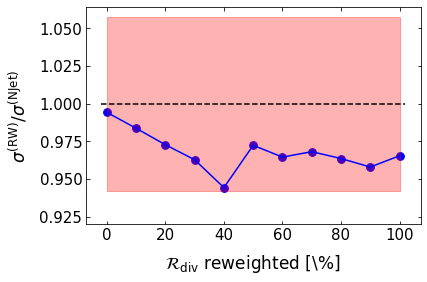

In [19]:
plt.scatter(np.array(reweight_props)*100, nn_xs_reweights/xs_compare, color="blue", s=60)
plt.plot(np.array(reweight_props)*100, nn_xs_reweights/xs_compare, color="blue")
plt.hlines(1.,-2,102, linestyles='--')
plt.fill_between(np.array(reweight_props)*100, 1-xs_compare_std/xs_compare, 1+xs_compare_std/xs_compare, color="red", alpha=0.3)

plt.tick_params(axis='x', labelsize=15, direction = 'in', top = True, which='both')
plt.tick_params(axis='y', labelsize=15, direction = 'in', right = True, which='both')

#plt.ylim((0.998,1.008))
plt.xlabel(r'$\mathcal{R}_{\mathrm{div}}$ reweighted [\%]', fontsize=17, labelpad=10)
plt.ylabel(r'$\sigma^{\mathrm{(RW)}}/\sigma^{\mathrm{(NJet)}}$', fontsize=17, labelpad=10)

#plt.savefig('./paper_plots/6_point/100k_unit_reweighting.pdf', dpi=150, bbox_inches='tight')
plt.show()